# Кластеризация: K-Means и DBSCAN + мини-проект “Активные клиенты”

---

## Что такое кластеризация?
**Кластеризация** — это задача машинного обучения **без учителя**, где мы:
- не знаем правильных ответов заранее,
- но хотим **разделить объекты на группы** по похожести.

Пример:
- клиенты с похожим поведением покупки
- города с похожим уровнем преступности
- изображения с похожими характеристиками
- товары с похожими отзывами

---

## Что вы сделаете сегодня
✅ сгенерируете “датасет клиентов” (как в CRM)  
✅ сделаете минимальный анализ (EDA)  
✅ подготовите признаки и масштабирование  
✅ обучите **K-Means** (и выберете K)  
✅ попробуете **DBSCAN** (кластеры + “выбросы”)  
✅ интерпретируете кластеры и составите “план продаж”  
✅ закрепите всё на **10 заданиях**

In [10]:
# Если запускаете локально и чего-то нет:
# !pip install pandas numpy scikit-learn matplotlib seaborn --quiet

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score

np.random.seed(42)
sns.set_style("whitegrid")
print("Ready ✅")

Ready ✅


# 1) Интуиция кластеризации

Представьте, что у нас есть точки на плоскости — клиенты.

- Если две точки близко друг к другу → клиенты похожи.
- Если далеко → клиенты разные.

Кластеризация — это попытка **разбить точки на группы**, чтобы:
- внутри группы объекты были похожи
- между группами — отличались

⚠️ В отличие от классификации, **нет правильных меток**.
Мы сами выбираем, как интерпретировать группы.

---

## Где это используется в продажах?
- “Премиальные” клиенты
- “Стабильно покупающие”
- “Потерянные” (давно не покупали)
- “Новые”
- “Охотники за скидками”


# 2) Данные: “клиенты для продаж” (учебная CRM-таблица)

В реальной жизни вы бы взяли таблицу из базы или CRM.  
Но на уроке мы **сгенерируем** маленький, понятный датасет.

## Какие признаки возьмём?
- **recency_days**: сколько дней прошло с последней покупки (меньше = активнее)
- **frequency_30d**: сколько покупок за последние 30 дней
- **monetary_30d**: сколько денег потратил за последние 30 дней
- **avg_check**: средний чек
- **tenure_months**: сколько месяцев клиент с нами (стаж)

Это похоже на классический подход **RFM**:
- R = Recency
- F = Frequency
- M = Monetary


In [11]:
import pandas as pd
import numpy as np

# 1. Load the real file
df = pd.read_csv(r"C:\Users\nikak\Downloads\Instagram visits clustering.csv") 

# 2. Handle missing data (Very important for clustering!)
# This fills any empty spots with the average of that column
df_fill = df.copy()
# We only fill the columns that are numbers
numeric_cols = ['Instagram visit score', 'Spending_rank(0 to 100)']
df_fill[numeric_cols] = df_fill[numeric_cols].fillna(df_fill[numeric_cols].mean())

# 3. Define your features for the AI
features = ['Instagram visit score', 'Spending_rank(0 to 100)']
X = df_fill[features].values

print("Data is cleaned and ready for clustering!")
df_fill.head()

Data is cleaned and ready for clustering!


,User ID,Instagram visit score,Spending_rank(0 to 100)
0,0,63,24.050708
1,1,61,25.223290
2,2,104,18.528245
3,3,82,86.890232
4,4,14,31.492397


# 3) Мини-EDA

Смотрим таблицу и пропуски.


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User ID                  2600 non-null   int64  
 1   Instagram visit score    2600 non-null   int64  
 2   Spending_rank(0 to 100)  2600 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 61.1 KB


In [13]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
User ID,2600.0,1299.500000,750.699674,0.000000,649.750000,1299.500000,1949.250000,2599.000000
Instagram visit score,2600.0,63.323462,26.579760,5.000000,38.000000,72.000000,86.000000,118.000000
Spending_rank(0 to 100),2600.0,42.848408,28.758349,0.940709,19.452098,28.013082,72.116945,107.349821


In [14]:
df.isna().sum().sort_values(ascending=False)

User ID                    0
Instagram visit score      0
Spending_rank(0 to 100)    0
dtype: int64

In [15]:
# Заполним пропуски медианой
df_filled = df.copy()
for col in df_filled.columns:
    df_filled[col] = df_filled[col].fillna(df_filled[col].median())

df_filled.isna().sum().sum()

np.int64(0)

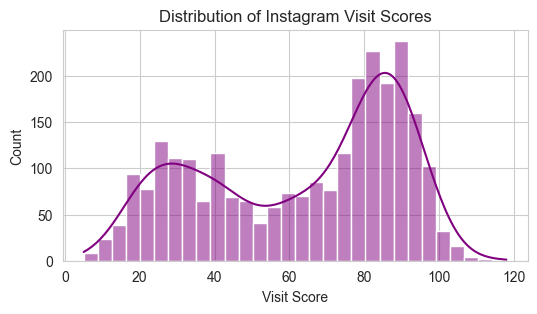

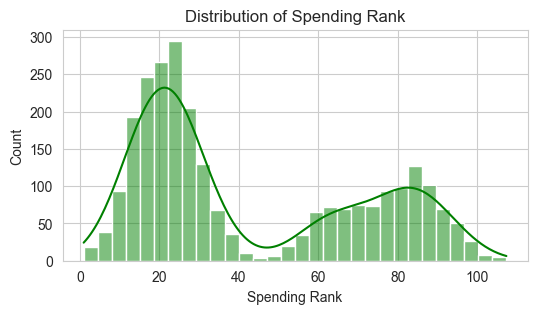

In [20]:

plt.figure(figsize=(6,3))
sns.histplot(df_filled["Instagram visit score"], bins=30, kde=True, color='purple')

plt.title("Distribution of Instagram Visit Scores")
plt.xlabel("Visit Score")
plt.grid(True)
plt.show()

plt.figure(figsize=(6,3))
sns.histplot(df_filled["Spending_rank(0 to 100)"], bins=30, kde=True, color='green')
plt.title("Distribution of Spending Rank")
plt.xlabel("Spending Rank")
plt.grid(True)
plt.show()

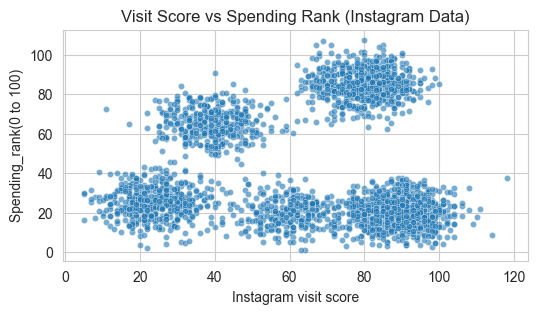

In [22]:
plt.figure(figsize=(6,3))


sns.scatterplot(
    data=df_filled, 
    x="Instagram visit score", 
    y="Spending_rank(0 to 100)", 
    s=20, 
    alpha=0.6
)

plt.title("Visit Score vs Spending Rank (Instagram Data)")
plt.grid(True)
plt.show()

# 4) Масштабирование (StandardScaler)

Важно, потому что кластеризация = расстояния.


In [23]:

features = ["Instagram visit score", "Spending_rank(0 to 100)"]

X = df_filled[features].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled mean:", X_scaled.mean(axis=0).round(3))
print("Scaled std :", X_scaled.std(axis=0).round(3))

Scaled mean: [ 0. -0.]
Scaled std : [1. 1.]


# 5) K-Means

Выбор K через Elbow + Silhouette.


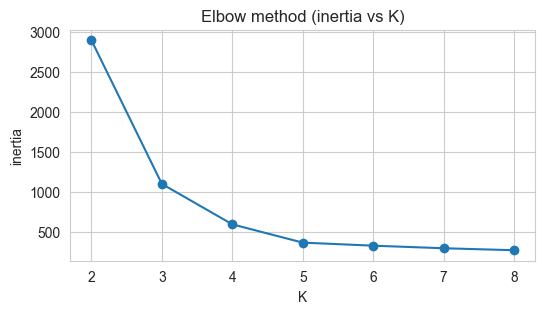

In [24]:
inertias = []
Ks = range(2, 9)

for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_scaled)
    inertias.append(km.inertia_)

plt.figure(figsize=(6,3))
plt.plot(list(Ks), inertias, marker="o")
plt.title("Elbow method (inertia vs K)")
plt.xlabel("K")
plt.ylabel("inertia")
plt.grid(True)
plt.show()

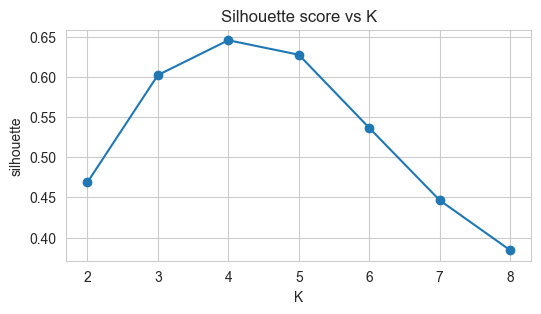

,K,silhouette
0,2,0.468714
1,3,0.602151
2,4,0.645579
3,5,0.627521
4,6,0.536477
5,7,0.446412
6,8,0.384213


In [25]:
sil_scores = []
for k in Ks:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = km.fit_predict(X_scaled)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(6,3))
plt.plot(list(Ks), sil_scores, marker="o")
plt.title("Silhouette score vs K")
plt.xlabel("K")
plt.ylabel("silhouette")
plt.grid(True)
plt.show()

pd.DataFrame({"K": list(Ks), "silhouette": sil_scores})

In [26]:
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_km = kmeans.fit_predict(X_scaled)

df_km = df_filled.copy()
df_km["cluster_kmeans"] = cluster_km

df_km["cluster_kmeans"].value_counts().sort_index()

cluster_kmeans
0    1027
1     400
2     600
3     573
Name: count, dtype: int64

In [27]:
df_km.groupby("cluster_kmeans")[features].mean().round(1)

,Instagram visit score,Spending_rank(0 to 100)
cluster_kmeans,,
0,83.2,19.9
1,39.4,65.1
2,79.6,85.0
3,27.3,24.3


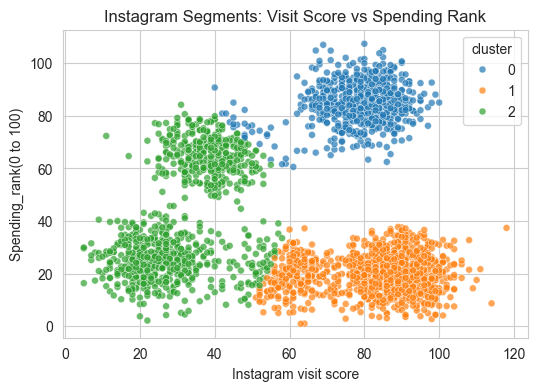

In [31]:
plt.figure(figsize=(6,4))


sns.scatterplot(
    data=df, 
    x="Instagram visit score", 
    y="Spending_rank(0 to 100)", 
    hue="cluster", 
    palette="tab10", 
    s=25, 
    alpha=0.7
)

plt.title("Instagram Segments: Visit Score vs Spending Rank")
plt.grid(True)
plt.show()

# 6) DBSCAN

Находит кластеры по плотности + выделяет шум (-1).


In [32]:
db = DBSCAN(eps=0.9, min_samples=12)
cluster_db = db.fit_predict(X_scaled)

df_db = df_filled.copy()
df_db["cluster_dbscan"] = cluster_db

df_db["cluster_dbscan"].value_counts().sort_index()

cluster_dbscan
0    2600
Name: count, dtype: int64

In [33]:
noise_rate = (df_db["cluster_dbscan"] == -1).mean()
print("Noise rate:", round(noise_rate, 3))

Noise rate: 0.0


In [34]:
df_db_no_noise = df_db[df_db["cluster_dbscan"] != -1]
df_db_no_noise.groupby("cluster_dbscan")[features].mean().round(1)

,Instagram visit score,Spending_rank(0 to 100)
cluster_dbscan,,
0,63.3,42.8


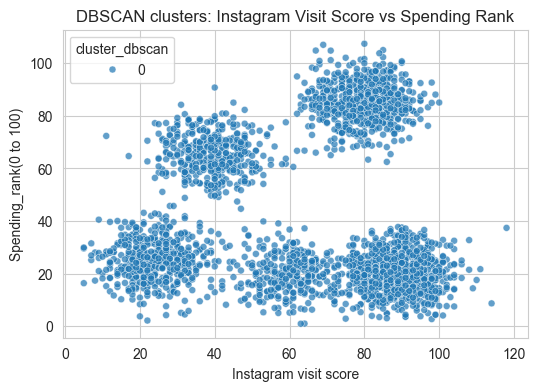

In [36]:
plt.figure(figsize=(6,4))


sns.scatterplot(
    data=df_db, 
    x="Instagram visit score", 
    y="Spending_rank(0 to 100)", 
    hue="cluster_dbscan", 
    palette="tab10", 
    s=25, 
    alpha=0.7
)

plt.title("DBSCAN clusters: Instagram Visit Score vs Spending Rank")
plt.grid(True)
plt.show()

# 7) Бизнес-задача: “активные клиенты” для продаж

Сделаем простой activity_score и найдём лучший кластер.


In [39]:

df["activity_score"] = (
    df["Instagram visit score"] * 0.6 + 
    df["Spending_rank(0 to 100)"] * 0.4
)

df.groupby("cluster")["activity_score"].mean().sort_values(ascending=False).round(2)


cluster
0    80.76
1    57.68
2    35.12
Name: activity_score, dtype: float64

In [43]:

best_cluster = df.groupby("cluster")["activity_score"].mean().idxmax()
print("Best cluster:", best_cluster)


df["is_active_segment"] = (df["cluster"] == best_cluster).astype(int)

print(df["is_active_segment"].value_counts())

Best cluster: 0
is_active_segment
0    1971
1     629
Name: count, dtype: int64


In [46]:

features = ["Instagram visit score", "Spending_rank(0 to 100)"]


df.groupby("is_active_segment")[features].mean().round(1)

,Instagram visit score,Spending_rank(0 to 100)
is_active_segment,,
0,58.6,29.6
1,78.3,84.5


---
# Итоги занятия
✅ K-Means и DBSCAN + сегментация активных клиентов + визуализация


# 10 заданий (код с пропусками)

Заполняйте `_____`.


## Задание 1

**Задание:** Посчитайте пропуски по колонкам.  


In [49]:
missing = df._____
missing.sort_values(ascending=False)

User ID                    3.378700e+06
Instagram visit score      1.646410e+05
activity_score             1.433469e+05
Spending_rank(0 to 100)    1.114059e+05
cluster                    2.908000e+03
is_active_segment          6.290000e+02
dtype: float64

## Задание 2

**Задание:** Заполните пропуски медианой в цикле.  


In [47]:
df_fill = df.copy()
for col in df_fill.columns:
    df_fill[col] = df_fill[col].fillna(df_fill[col]._____)
df_fill.isna().sum()

User ID                    0
Instagram visit score      0
Spending_rank(0 to 100)    0
cluster                    0
activity_score             0
is_active_segment          0
dtype: int64

## Задание 3

**Задание:** Сделайте StandardScaler и X_scaled.  


In [50]:
from sklearn.preprocessing import StandardScaler
features = ["recency_days", "frequency_30d", "monetary_30d", "avg_check", "tenure_months"]
X = df_fill[features].values

scaler = StandardScaler()
X_scaled = scaler._____(X)
print(X_scaled.shape)

KeyError: "None of [Index(['recency_days', 'frequency_30d', 'monetary_30d', 'avg_check',\n       'tenure_months'],\n      dtype='object')] are in the [columns]"

## Задание 4

**Задание:** Обучите KMeans K=4 и получите labels.


In [ ]:
from sklearn.cluster import KMeans
km = KMeans(n_clusters=_____, random_state=42, n_init=10)
labels = km._____(X_scaled)
pd.Series(labels).value_counts().sort_index()

## Задание 5

**Задание:** Посчитайте silhouette score.


In [ ]:
from sklearn.metrics import silhouette_score
score = silhouette_score(_____, _____)
print(round(score, 3))

## Задание 6

**Задание:** Добавьте кластер в df и посчитайте средние.  


In [ ]:
df_k = df_fill.copy()
df_k["cluster"] = _____
df_k.groupby("_____")[features].mean().round(1)

## Задание 7

**Задание:** Нарисуйте scatterplot по кластерам.  


In [ ]:
plt.figure(figsize=(6,4))
sns.scatterplot(data=df_k, x="frequency_30d", y="monetary_30d", hue="_____", s=25, alpha=0.7)
plt.grid(True)
plt.show()

## Задание 8

**Задание:** DBSCAN и доля шума (-1).


In [ ]:
from sklearn.cluster import DBSCAN
db = DBSCAN(eps=_____, min_samples=_____)
labels_db = db.fit_predict(X_scaled)

noise_rate = (labels_db == _____).mean()
print(round(noise_rate, 3))

## Задание 9

**Задание:** Сделайте activity_score и найдите лучший кластер.


In [ ]:
df_k["activity_score"] = (
    df_k["frequency_30d"] * _____ +
    df_k["monetary_30d"] * _____ +
    (-df_k["recency_days"]) * _____
)

best_cluster = df_k.groupby("_____")["activity_score"].mean().idxmax()
print(best_cluster)

## Задание 10

**Задание:** Сделайте флаг активного сегмента.


In [ ]:
df_k["is_active_segment"] = (df_k["cluster"] == _____).astype(int)
df_k["is_active_segment"].value_counts()
